## Preliminary evaluation of DOE oil IMPORT data
- Crude oil export counted if deliverer is a refinery or terminal
- No ship-to-ship transfers included (yet).  This means that tanker volume estimates may be disproportionately higher than actual if tankers act as fueling hub for ATBs and tugs
- All non-ATBs and non-tugs are categorized tankers
- Oil volumes organized by vessel type and by fuel type
- I am missing 11% of oil export in my plots of oil export by transport type and fuel type (see percent_check in Out[11])

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# User inputs
file_dir  = '/Users/rmueller/Documents/UBC/MIDOSS/Data/DeptOfEcology/'
file_name = 'MuellerTrans4-30-20.xlsx'

In [3]:
# Import columns are: (E) 'StartDateTime, (G) Deliverer, (H) Receiver, (N) City, (P) Product, (Q) Quantity in Gallons, (R) Transfer Type (Fueling, Cargo, or Other)'
df = pd.read_excel(f'{file_dir}{file_name}',sheet_name='Vessel Oil Transfer', 
                   usecols="E,G,H,N,P,Q,R")

### Extract data for oil cargo transferred to vessels for marine export approximation

In [4]:
# Get all cargo fuel transfers
bool_cargo = df['TransferType']=='Cargo'
cargo_data = df[bool_cargo]

In [5]:
oil_traffic = {}
oil_traffic['destination']={}

for reciever in cargo_data.Receiver:
    # create a list of all recieving entities
    if reciever not in oil_traffic['destination']:
        oil_traffic['destination'][f'{reciever}'] = 0
    # create a list of all refinery destinations
    #if receiver.str.contains('Refinery')
#oil_traffic['destination']

### Evaluate marine oil import

#### By vessel type (I still need to remove Vancouver, WA)

In [6]:
# define list of strings that can be used to tag names for WA state refineries and terminals
# still in verification phase around accurately selecting Salish Sea marine terminals.  
# Check to see if Vancouver terminals are included in "export cargo" dataframe
oil_traffic['refinery_tags'] = ['Refinery', 'Refining']
oil_traffic['terminal_tags']  = ['Terminal', 'Petroleum', 'Inc', 'LLC', 'Ballard Oil Co.', 'Reisner Distributor, Inc.','NASWI']

In [8]:
# create dataset of import cargo in which import cargo is defined as
# all cargo being deliverd to (land-based) marine terminal
cargo_import = cargo_data[cargo_data.Receiver.str.contains(oil_traffic['refinery_tags'][0])]
cargo_import = cargo_import.append(cargo_data[cargo_data.Receiver.str.contains(oil_traffic['refinery_tags'][1])])

# add oil from terminal locations
for terminal_origin in oil_traffic['terminal_tags']:
    display(terminal_origin)
    cargo_import = cargo_import.append(
        cargo_data[cargo_data.Receiver.str.contains(f'{terminal_origin}')]
    )
    
# need to re-set indexing in order to use row-index as data_frame index
cargo_import.reset_index(drop=True, inplace=True)    

'Terminal'

'Petroleum'

'Inc'

'LLC'

'Ballard Oil Co.'

'Reisner Distributor, Inc.'

'NASWI'

In [10]:
# introduce dictionary for cargo traffic
oil_traffic['cargo'] = {}

# ATB fuel export
oil_traffic['cargo']['atb']                           = {}
oil_traffic['cargo']['atb']['percent_volume_import']  = {} # percentage of total crude export by oil type 
oil_traffic['cargo']['atb']['volume_import_total']    = 0
oil_traffic['cargo']['atb']['volume_import']          = [] # a vector of volumes ordered to pair with oil_type
oil_traffic['cargo']['atb']['oil_type']               = [] # a vector of oil types ordered to pair with volume_export

# barge fuel export
oil_traffic['cargo']['barge']                           = {}
oil_traffic['cargo']['barge']['percent_volume_import']  = {}
oil_traffic['cargo']['barge']['volume_import_total']    = 0
oil_traffic['cargo']['barge']['volume_import']          = []
oil_traffic['cargo']['barge']['oil_type']               = []

# tanker fuel export
oil_traffic['cargo']['tanker']                           = {}
oil_traffic['cargo']['tanker']['percent_volume_import']  = {}
oil_traffic['cargo']['tanker']['volume_import_total']    = 0
oil_traffic['cargo']['tanker']['volume_import']          = []
oil_traffic['cargo']['tanker']['oil_type']               = []

# total
oil_traffic['cargo']['total']                = []

# identify ship traffic 
[nrows,ncols] = cargo_import.shape

# total up volume of oil transferred onto ATB BARGES, non-ATB barges, and other vessels
# create counter for vessel-type
atb_counter = 0
barge_counter = 0
tanker_counter = 0
for rows in range(nrows):
    if 'ATB' in cargo_import.Receiver[rows]: 
        oil_traffic['cargo']['atb']['volume_import_total'] += cargo_import.TransferQtyInGallon[rows]
        oil_traffic['cargo']['atb']['volume_import'].append(cargo_import.TransferQtyInGallon[rows])
        oil_traffic['cargo']['atb']['oil_type'] .append(cargo_import.Product[rows])
        atb_counter += 1
    elif ('BARGE' in cargo_import.Receiver[rows] or \
        'Barge'   in cargo_import.Receiver[rows] or \
        'PB'      in cargo_import.Receiver[rows] or \
        'YON'     in cargo_import.Receiver[rows] or \
        'DLB'     in cargo_import.Receiver[rows]): 
        oil_traffic['cargo']['barge']['volume_import_total'] += cargo_import.TransferQtyInGallon[rows] 
        oil_traffic['cargo']['barge']['volume_import'].append(cargo_import.TransferQtyInGallon[rows])
        oil_traffic['cargo']['barge']['oil_type'].append(cargo_import.Product[rows])
        barge_counter += 1
        #display(cargo_data.Receiver[rows])
    else:
        oil_traffic['cargo']['tanker']['volume_import_total'] += cargo_import.TransferQtyInGallon[rows] 
        oil_traffic['cargo']['tanker']['volume_import'].append(cargo_import.TransferQtyInGallon[rows])
        oil_traffic['cargo']['tanker']['oil_type'].append(cargo_import.Product[rows])
        tanker_counter += 1
        #display(cargo_data.Receiver[rows])

oil_traffic['cargo']['total'] = oil_traffic['cargo']['atb']['volume_import_total'] + oil_traffic['cargo']['barge']['volume_import_total'] + oil_traffic['cargo']['tanker']['volume_import_total'] 

In [11]:
# Calculate percent of total transport by vessel type
atb_percent = 100*oil_traffic['cargo']['atb']['volume_import_total']/oil_traffic['cargo']['total']
barge_percent = 100*oil_traffic['cargo']['barge']['volume_import_total']/oil_traffic['cargo']['total']
tanker_percent = 100*oil_traffic['cargo']['tanker']['volume_import_total']/oil_traffic['cargo']['total']
print(atb_percent)
print(barge_percent)
print(tanker_percent)

0.0
0.0
100.0


Text(0.5,1,'Types of vessels by volume transporting oil as cargo to land-based platform identified as terminal or refinery')

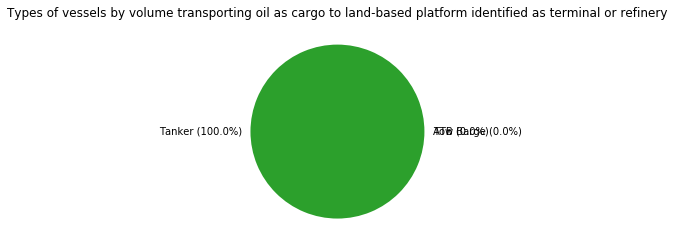

In [12]:
volume_export_byvessel = [oil_traffic['cargo']['atb']['volume_import_total'], oil_traffic['cargo']['barge']['volume_import_total'], oil_traffic['cargo']['tanker']['volume_import_total']]
#colors = ['b', 'g', 'r', 'c', 'm', 'y']
labels = [f'ATB ({atb_percent:3.1f}%)', f'Tow Barge ({barge_percent:3.1f}%)',f'Tanker ({tanker_percent:3.1f}%)']
plt.gca().axis("equal")
plt.pie(volume_export_byvessel, labels= labels)
plt.title('Types of vessels by volume transporting oil as cargo to land-based platform identified as terminal or refinery')

#### By oil type within vessel type classification

In [14]:
oil_traffic['cargo']['atb']['CRUDE']=0
oil_traffic['cargo']['atb']['GASOLINE']=0
oil_traffic['cargo']['atb']['JET FUEL/KEROSENE']=0
oil_traffic['cargo']['atb']['DIESEL/MARINE GAS OIL']=0
oil_traffic['cargo']['atb']['DIESEL LOW SULPHUR (ULSD)']=0
oil_traffic['cargo']['atb']['BUNKER OIL/HFO']=0
oil_traffic['cargo']['atb']['other']=0

oil_traffic['cargo']['barge']['CRUDE']=0
oil_traffic['cargo']['barge']['GASOLINE']=0
oil_traffic['cargo']['barge']['JET FUEL/KEROSENE']=0
oil_traffic['cargo']['barge']['DIESEL/MARINE GAS OIL']=0
oil_traffic['cargo']['barge']['DIESEL LOW SULPHUR (ULSD)']=0
oil_traffic['cargo']['barge']['BUNKER OIL/HFO']=0
oil_traffic['cargo']['barge']['other']=0

oil_traffic['cargo']['tanker']['CRUDE']=0
oil_traffic['cargo']['tanker']['GASOLINE']=0
oil_traffic['cargo']['tanker']['JET FUEL/KEROSENE']=0
oil_traffic['cargo']['tanker']['DIESEL/MARINE GAS OIL']=0
oil_traffic['cargo']['tanker']['DIESEL LOW SULPHUR (ULSD)']=0
oil_traffic['cargo']['tanker']['BUNKER OIL/HFO']=0
oil_traffic['cargo']['tanker']['other']=0

oil_types = ['CRUDE', 'GASOLINE', 'JET FUEL/KEROSENE','DIESEL/MARINE GAS OIL', 
             'DIESEL LOW SULPHUR (ULSD)', 'BUNKER OIL/HFO', 'other']

percent_check = 0
for oil_name in range(len(oil_types)):
    
    # ATBs
    for rows in range(len(oil_traffic['cargo']['atb']['volume_import'])):  
        if oil_types[oil_name] in oil_traffic['cargo']['atb']['oil_type'][rows]: 
            oil_traffic['cargo']['atb'][oil_types[oil_name]] += oil_traffic['cargo']['atb']['volume_import'][rows]
    
    # Barges
    for rows in range(len(oil_traffic['cargo']['barge']['volume_import'])):  
        if oil_types[oil_name] in oil_traffic['cargo']['barge']['oil_type'][rows]: 
            oil_traffic['cargo']['barge'][oil_types[oil_name]] += oil_traffic['cargo']['barge']['volume_import'][rows]
    
    # Tankers (non-ATB or Barge)
    for rows in range(len(oil_traffic['cargo']['tanker']['volume_import'])):  
        if oil_types[oil_name] in oil_traffic['cargo']['tanker']['oil_type'][rows]: 
            oil_traffic['cargo']['tanker'][oil_types[oil_name]] += oil_traffic['cargo']['tanker']['volume_import'][rows]
    
    # calculate percentages based on total oil cargo exports
    oil_traffic['cargo']['atb']['percent_volume_import'][oil_types[oil_name]]    = 100 * oil_traffic['cargo']['atb'][oil_types[oil_name]]/oil_traffic['cargo']['total']
    oil_traffic['cargo']['barge']['percent_volume_import'][oil_types[oil_name]]  = 100 * oil_traffic['cargo']['barge'][oil_types[oil_name]]/oil_traffic['cargo']['total']
    oil_traffic['cargo']['tanker']['percent_volume_import'][oil_types[oil_name]] = 100 * oil_traffic['cargo']['tanker'][oil_types[oil_name]]/oil_traffic['cargo']['total']

    for name in ['atb', 'barge', 'tanker']:
        percent_check += oil_traffic['cargo'][f'{name}']['percent_volume_import'][oil_types[oil_name]]

percent_check        

93.15094756791288

#### Plot up ATB fuel types

Text(0.5,1,'Types of oil transport by volume for ATBs to WA refineries and terminals')

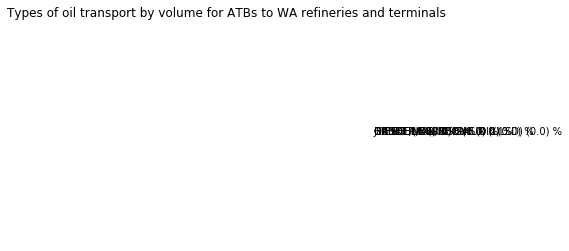

In [15]:
atb_volume_import = [oil_traffic['cargo']['atb']['CRUDE'],
                    oil_traffic['cargo']['atb']['GASOLINE'],
                    oil_traffic['cargo']['atb']['JET FUEL/KEROSENE'],
                    oil_traffic['cargo']['atb']['DIESEL/MARINE GAS OIL'],
                    oil_traffic['cargo']['atb']['DIESEL LOW SULPHUR (ULSD)'],
                    oil_traffic['cargo']['atb']['BUNKER OIL/HFO']]
labels = []
for ii in range(len(oil_types)-1):
    labels.append(f'{oil_types[ii]} ({oil_traffic["cargo"]["atb"]["percent_volume_import"][oil_types[ii]]:3.1f}) %')
    
plt.gca().axis("equal")
plt.pie(atb_volume_import, labels= labels)
plt.title('Types of oil transport by volume for ATBs to WA refineries and terminals')

#### Plot up Barge fuel types

Text(0.5,1,'Types of oil transport by volume for barges to WA refineries and terminals')

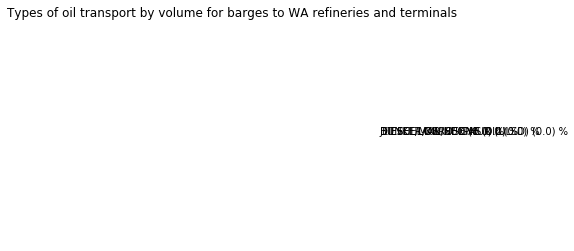

In [16]:
# barge_volume_export = [oil_traffic['cargo']['barge']['CRUDE'],
#                     oil_traffic['cargo']['barge']['GASOLINE'],
#                     oil_traffic['cargo']['barge']['JET FUEL/KEROSENE'],
#                     oil_traffic['cargo']['barge']['DIESEL/MARINE GAS OIL'],
#                     oil_traffic['cargo']['barge']['DIESEL LOW SULPHUR (ULSD)'],
#                     oil_traffic['cargo']['barge']['BUNKER OIL/HFO'],
#                     oil_traffic['cargo']['barge']['other']]
barge_volume_import = [oil_traffic['cargo']['barge']['JET FUEL/KEROSENE'],
                    oil_traffic['cargo']['barge']['DIESEL/MARINE GAS OIL'],
                    oil_traffic['cargo']['barge']['DIESEL LOW SULPHUR (ULSD)'],
                    oil_traffic['cargo']['barge']['BUNKER OIL/HFO']]
labels = []
for ii in [2,3,4,5]:
    labels.append(f'{oil_types[ii]} ({oil_traffic["cargo"]["barge"]["percent_volume_import"][oil_types[ii]]:3.1f}) %')

plt.gca().axis("equal")
plt.pie(barge_volume_import, labels= labels)
plt.title('Types of oil transport by volume for barges to WA refineries and terminals')

#### Plot up Tanker fuel types

Text(0.5,1,'Types of oil transport by volume for tankers to WA refineries and terminals\n with percent of net crude export')

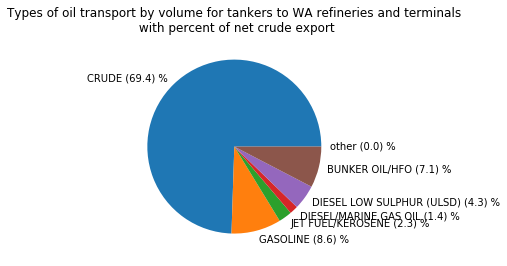

In [17]:
tanker_volume_import = [oil_traffic['cargo']['tanker']['CRUDE'],
                    oil_traffic['cargo']['tanker']['GASOLINE'],
                    oil_traffic['cargo']['tanker']['JET FUEL/KEROSENE'],
                    oil_traffic['cargo']['tanker']['DIESEL/MARINE GAS OIL'],
                    oil_traffic['cargo']['tanker']['DIESEL LOW SULPHUR (ULSD)'],
                    oil_traffic['cargo']['tanker']['BUNKER OIL/HFO'],
                    oil_traffic['cargo']['tanker']['other']]
labels = []
for ii in range(len(oil_types)):
    labels.append(f'{oil_types[ii]} ({oil_traffic["cargo"]["tanker"]["percent_volume_import"][oil_types[ii]]:3.1f}) %')

plt.gca().axis("equal")
plt.pie(tanker_volume_import, labels= labels)
plt.title('Types of oil transport by volume for tankers to WA refineries and terminals\n with percent of net crude export')